✓ Libraries imported successfully

[1] Loading dataset...
✓ Dataset loaded successfully
   Shape: (10000, 17)
   Samples: 10000

First 5 rows:
   Patient_ID  Age  Gender   BMI Smoking_Status  Family_History Allergies  \
0  ASTH100000   52  Female  27.6         Former               1       NaN   
1  ASTH100001   15    Male  24.6         Former               0      Dust   
2  ASTH100002   72  Female  17.6          Never               0       NaN   
3  ASTH100003   61    Male  16.8          Never               0  Multiple   
4  ASTH100004   21    Male  30.2          Never               0       NaN   

  Air_Pollution_Level Physical_Activity_Level Occupation_Type Comorbidities  \
0            Moderate               Sedentary         Outdoor      Diabetes   
1                 Low                Moderate          Indoor          Both   
2            Moderate                Moderate          Indoor           NaN   
3                High               Sedentary         Outdoor          Both   

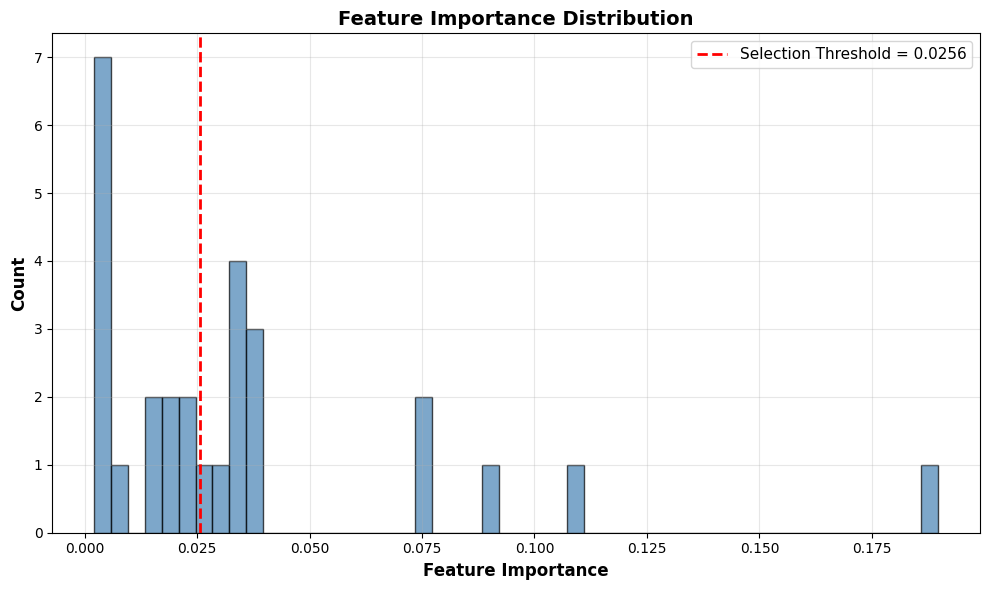

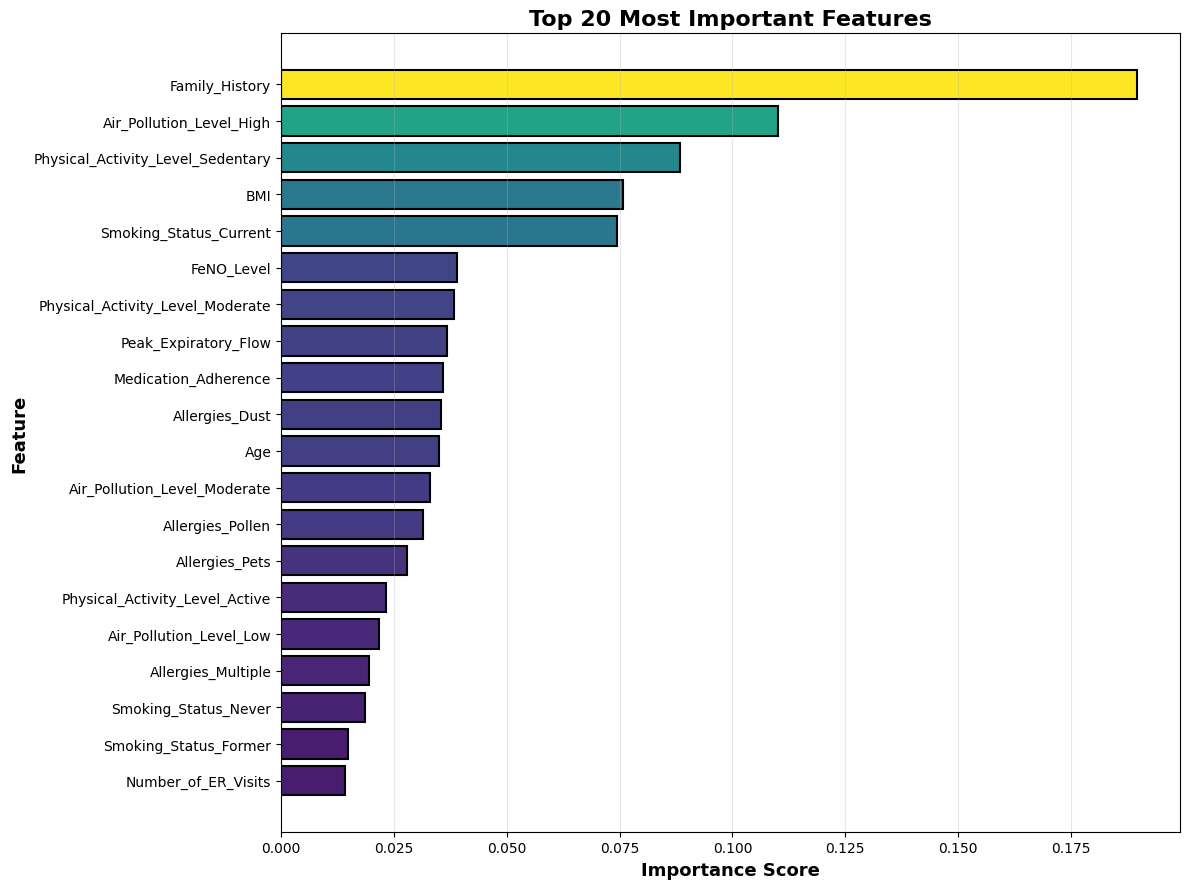


Top 10 Most Important Features:
   Family_History: 0.1897
   Air_Pollution_Level_High: 0.1102
   Physical_Activity_Level_Sedentary: 0.0884
   BMI: 0.0759
   Smoking_Status_Current: 0.0745
   FeNO_Level: 0.0389
   Physical_Activity_Level_Moderate: 0.0383
   Peak_Expiratory_Flow: 0.0368
   Medication_Adherence: 0.0358
   Allergies_Dust: 0.0355

[6] Hyperparameter tuning with RandomizedSearchCV...

Hyperparameter Search Space:
   n_estimators: [100, 200, 300, 500]
   max_depth: [10, 15, 20, 25, None]
   min_samples_split: [2, 5, 10, 15]
   min_samples_leaf: [1, 2, 4]
   max_features: ['sqrt', 'log2', None]
   class_weight: ['balanced', None]
   criterion: ['gini', 'entropy']

Starting hyperparameter search...
   Method: RandomizedSearchCV
   Iterations: 100 random combinations
   Cross-validation: 5-fold stratified
   Total model fits: 100 × 5 = 500

   ⏳ Training in progress...


HYPERPARAMETER TUNING RESULTS

✓ Training completed in 4.04 minutes

📊 Best Parameters Found:
   • n_estimat

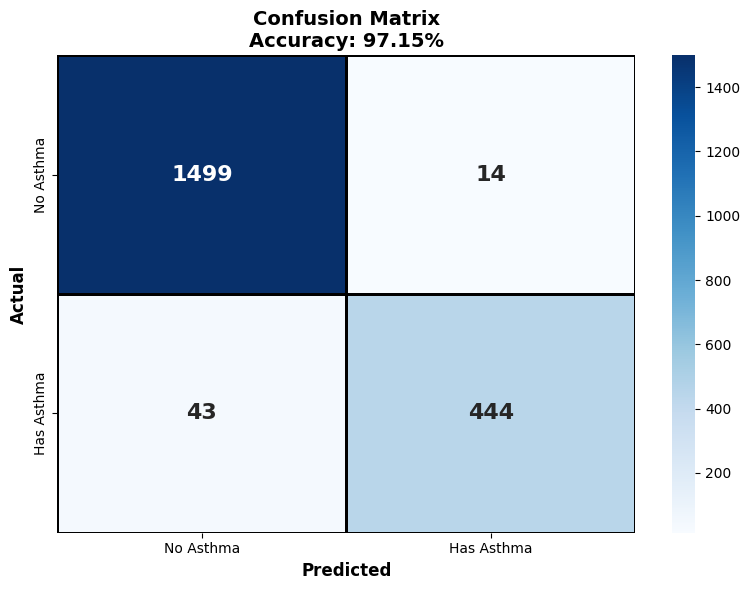


Confusion Matrix Breakdown:
   True Negatives (No Asthma correctly predicted):  1499
   False Positives (No Asthma predicted as Has):    14
   False Negatives (Has Asthma predicted as No):    43
   True Positives (Has Asthma correctly predicted): 444

[10] Creating ROC curve...


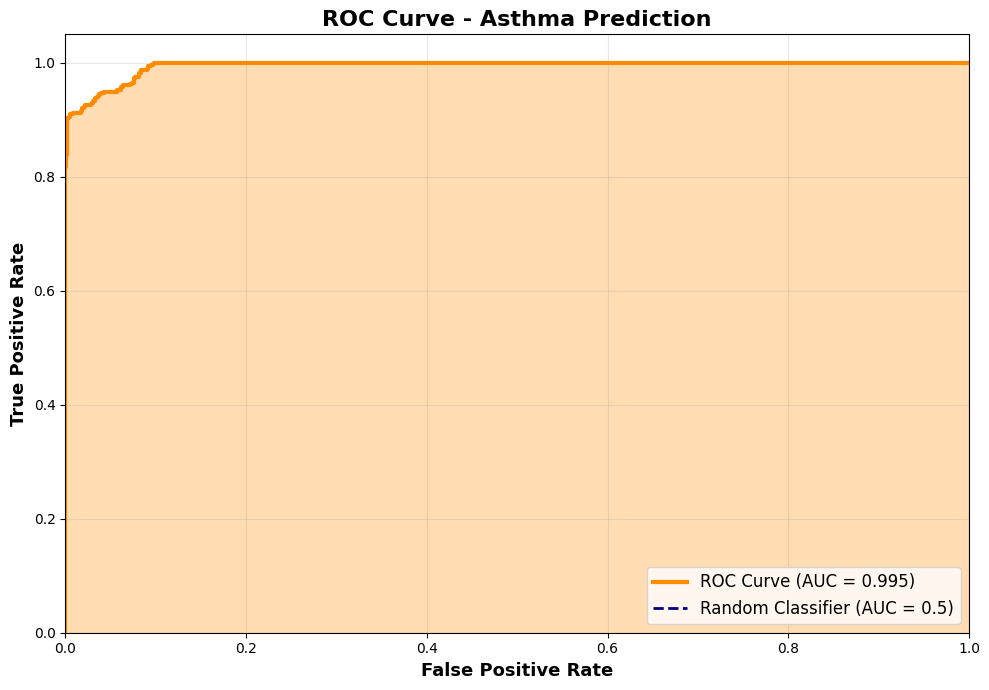


📊 ROC AUC Score: 0.9947

AUC Interpretation:
   ✅ EXCELLENT - Near perfect discrimination

[11] Creating Precision-Recall curve...


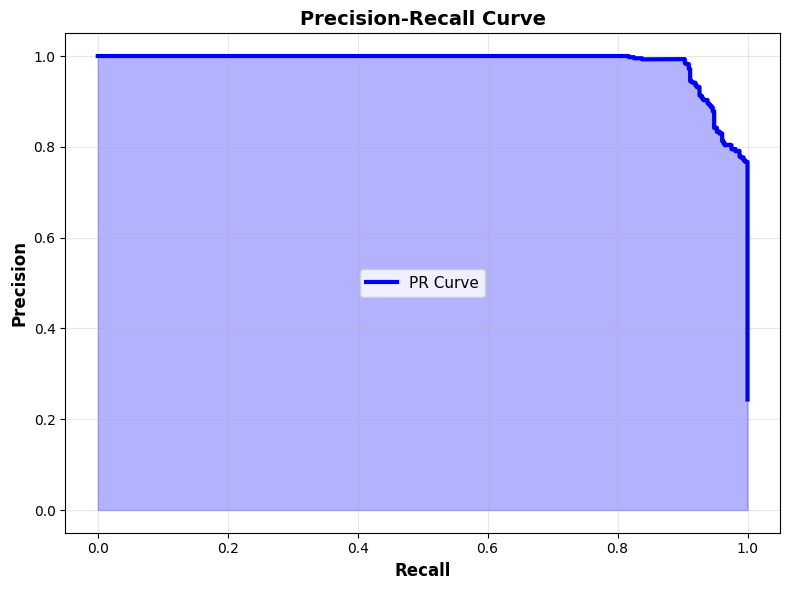

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score, 
    roc_curve, auc, precision_recall_curve, matthews_corrcoef
)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import time

import warnings
import sys
import os
from sklearn.exceptions import ConvergenceWarning

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

print("✓ Libraries imported successfully")

# Step 1: Load the dataset
print("\n[1] Loading dataset...")

try:
    df = pd.read_csv('synthetic_asthma_dataset.csv')
    print("✓ Dataset loaded successfully")
    print(f"   Shape: {df.shape}")
    print(f"   Samples: {len(df)}")
except FileNotFoundError:
    print("❌ Error: 'synthetic_asthma_dataset.csv' not found.")

print("\nFirst 5 rows:")
print(df.head())

print("\nDataset Information:")
print("="*60)
print(f"Total samples: {len(df)}")
print(f"Total columns: {len(df.columns)}")
print(f"\nColumn names: {df.columns.tolist()}")
print(f"\nMissing values:\n{df.isnull().sum()}")
print(f"\nTarget distribution:\n{df['Has_Asthma'].value_counts()}")


# Step 2: Prepare features and target
print("\n[2] Preparing features and target...")

target = df['Has_Asthma']
features = df.drop(columns=['Patient_ID', 'Has_Asthma', 'Asthma_Control_Level'])
features_encoded = pd.get_dummies(features)

print(f"✓ Data prepared")
print(f"   Features after encoding: {features_encoded.shape[1]}")
print(f"   Target samples: {len(target)}")

# Step 3: Split data into training and test sets
print("\n[3] Splitting data into train and test sets...")

X_train, X_test, y_train, y_test = train_test_split(
    features_encoded, target, 
    test_size=0.2, 
    random_state=42, 
    stratify=target
)

print("✓ Data split complete")
print(f"   Training samples: {len(X_train)}")
print(f"   Test samples: {len(X_test)}")
print(f"\n   Training target distribution:\n{y_train.value_counts()}")
print(f"\n   Test target distribution:\n{y_test.value_counts()}")

# Step 4: Standardize features
print("\n[4] Scaling features...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Feature scaling complete")
print(f"   Scaled training shape: {X_train_scaled.shape}")
print(f"   Scaled test shape: {X_test_scaled.shape}")

# Step 5: Feature selection with Random Forest
print("\n[5] Performing feature selection with Random Forest...")

rf_selector = RandomForestClassifier(
    n_estimators=100, 
    random_state=42,
    n_jobs=-1
)

rf_selector.fit(X_train_scaled, y_train)

importances = rf_selector.feature_importances_
threshold = np.median(importances[importances > 0])
selected_features_mask = importances >= threshold
selected_feature_names = features_encoded.columns[selected_features_mask]

X_train_selected = X_train_scaled[:, selected_features_mask]
X_test_selected = X_test_scaled[:, selected_features_mask]

print(f"\n✓ Feature selection complete")
print(f"   Original features: {X_train_scaled.shape[1]}")
print(f"   Selected features: {X_train_selected.shape[1]}")
print(f"   Reduction: {(1 - X_train_selected.shape[1]/X_train_scaled.shape[1])*100:.1f}%")

feature_importance_df = pd.DataFrame({
    'feature': features_encoded.columns,
    'importance': importances
}).sort_values('importance', ascending=False)

print(f"\nTop 10 most important features:")
for idx, row in feature_importance_df.head(10).iterrows():
    print(f"   {row['feature']}: {row['importance']:.4f}")

plt.figure(figsize=(10, 6))
plt.hist(importances, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
plt.axvline(threshold, color='red', linestyle='--', linewidth=2, 
            label=f'Selection Threshold = {threshold:.4f}')
plt.xlabel('Feature Importance', fontsize=12, fontweight='bold')
plt.ylabel('Count', fontsize=12, fontweight='bold')
plt.title('Feature Importance Distribution', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Top 20 important features

top_20 = feature_importance_df.head(20)

plt.figure(figsize=(12, 9))
plt.barh(range(len(top_20)), top_20['importance'], 
         color=plt.cm.viridis(top_20['importance']/top_20['importance'].max()),
         edgecolor='black', linewidth=1.5)
plt.yticks(range(len(top_20)), top_20['feature'], fontsize=10)
plt.xlabel('Importance Score', fontsize=13, fontweight='bold')
plt.ylabel('Feature', fontsize=13, fontweight='bold')
plt.title('Top 20 Most Important Features', fontsize=16, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
for idx, row in top_20.head(10).iterrows():
    print(f"   {row['feature']}: {row['importance']:.4f}")


# Step 6: Hyperparameter tuning with RandomizedSearchCV
print("\n[6] Hyperparameter tuning with RandomizedSearchCV...")
print("="*70)

param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 15, 20, 25, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'class_weight': ['balanced', None],
    'criterion': ['gini', 'entropy']
}

print("\nHyperparameter Search Space:")
for param, values in param_dist.items():
    print(f"   {param}: {values}")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_dist,
    n_iter=100,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=0,
    random_state=42
)

print(f"\nStarting hyperparameter search...")
print(f"   Method: RandomizedSearchCV")
print(f"   Iterations: 100 random combinations")
print(f"   Cross-validation: 5-fold stratified")
print(f"   Total model fits: 100 × 5 = 500")
print(f"\n   ⏳ Training in progress...\n")

start_time = time.time()
random_search.fit(X_train_selected, y_train)
end_time = time.time()

model = random_search.best_estimator_

print("\n" + "="*70)
print("HYPERPARAMETER TUNING RESULTS")
print("="*70)

elapsed_time = (end_time - start_time) / 60
print(f"\n✓ Training completed in {elapsed_time:.2f} minutes")

print(f"\n📊 Best Parameters Found:")
for param, value in random_search.best_params_.items():
    print(f"   • {param}: {value}")

print(f"\n🎯 Performance:")
print(f"   Best CV Accuracy: {random_search.best_score_:.4f} ({random_search.best_score_*100:.2f}%)")

print(f"\n📈 Model Summary:")
print(f"   Algorithm: Random Forest (Hyperparameter Tuned)")
print(f"   Number of trees: {model.n_estimators}")
print(f"   Max depth: {model.max_depth if model.max_depth else 'Unlimited'}")
print(f"   Criterion: {model.criterion}")
print(f"   Class weight: {model.class_weight}")

print("\n✓ Model training complete with optimized hyperparameters!")
print("="*70)

# Step 7: Make predictions on test set
print("\n[7] Making predictions...")

y_pred = model.predict(X_test_selected)
y_pred_proba = model.predict_proba(X_test_selected)[:, 1]

print("✓ Predictions complete")
print(f"   Predicted samples: {len(y_pred)}")
print(f"\n   Prediction distribution:")
print(pd.Series(y_pred).value_counts())

# Step 8: Calculate evaluation metrics
print("\n[8] Evaluating model performance...")

accuracy = accuracy_score(y_test, y_pred)

print("="*70)
print("MODEL EVALUATION - RANDOM FOREST")
print("="*70)
print(f"\nAccuracy: {accuracy * 100:.2f}%")

print("\nClassification Report:")
print("="*70)
print(classification_report(y_test, y_pred, target_names=['No Asthma', 'Has Asthma'], zero_division=0))

mcc = matthews_corrcoef(y_test, y_pred)

print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

# Step 9: Create and visualize confusion matrix
print("\n[9] Creating confusion matrix...")

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Asthma', 'Has Asthma'],
            yticklabels=['No Asthma', 'Has Asthma'],
            annot_kws={'size': 16, 'fontweight': 'bold'},
            linewidths=2, linecolor='black')
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.title(f'Confusion Matrix\nAccuracy: {accuracy*100:.2f}%', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


tn, fp, fn, tp = conf_matrix.ravel()
print(f"\nConfusion Matrix Breakdown:")
print(f"   True Negatives (No Asthma correctly predicted):  {tn}")
print(f"   False Positives (No Asthma predicted as Has):    {fp}")
print(f"   False Negatives (Has Asthma predicted as No):    {fn}")
print(f"   True Positives (Has Asthma correctly predicted): {tp}")

# Step 10: Plot ROC curve
print("\n[10] Creating ROC curve...")

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='darkorange', lw=3, 
         label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.fill_between(fpr, tpr, alpha=0.3, color='darkorange')
plt.plot(thresholds, color='navy', lw=2, linestyle='--', 
         label='Random Classifier (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=13, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=13, fontweight='bold')
plt.title('ROC Curve - Asthma Prediction', fontsize=16, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n📊 ROC AUC Score: {roc_auc:.4f}")
print(f"\nAUC Interpretation:")
if roc_auc >= 0.95:
    print(f"   ✅ EXCELLENT - Near perfect discrimination")
elif roc_auc >= 0.9:
    print(f"   ✅ EXCELLENT - Outstanding performance")
elif roc_auc >= 0.8:
    print(f"   ✓ GOOD - Acceptable discrimination")
else:
    print(f"   ⚠️  Needs improvement")

# Step 11: Plot Precision-Recall curve
print("\n[11] Creating Precision-Recall curve...")

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=3, label='PR Curve')
plt.fill_between(recall, precision, alpha=0.3, color='blue')
plt.xlabel('Recall', fontsize=12, fontweight='bold')
plt.ylabel('Precision', fontsize=12, fontweight='bold')
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.legend(loc="best", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

